In [2]:
from IPython.display import clear_output
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import re

import sys
import dropbox
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import logging
import datetime
import glob
import json
import scipy
import matplotlib as mpl
from amftrack.util.dbx import load_dbx

from amftrack.pipeline.development.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
    
)

%matplotlib widget
%load_ext autoreload
%autoreload 2
logging.basicConfig(stream=sys.stdout, level=logging.debug)
mpl.rcParams['figure.dpi'] = 200

print("import great succes!")
%reload_ext autoreload

import great succes!


/gpfs/home6/svstaalduine/AMF_project/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
analysis_folder="/gpfs/home6/svstaalduine/Analysis/CocoTransport/"

excel_address = "/Daan te Rietmole/SpeedCheck.xlx"

analysis_filter = "20230906_Plate310/"

In [4]:
%%time
edgedata = glob.glob(analysis_folder+analysis_filter+"*/*.csv")
print(len(edgedata))
print(analysis_folder+analysis_filter+"*/*.csv")

122
/gpfs/home6/svstaalduine/Analysis/CocoTransport/20230906_Plate310/*/*.csv
CPU times: user 5.68 ms, sys: 10.3 ms, total: 16 ms
Wall time: 104 ms


In [5]:
df1 = pd.read_csv(edgedata[0])
print(df1)

   Unnamed: 0 edge_name  edge_length  straight_length  speed_max  speed_min  \
0           0  (42, 32)       56.580       128.663151   3.327353  -4.908571   
1           0  (36, 34)       38.226        67.764043   3.872896  -8.630762   
2           0  (38, 37)       36.846        64.754212   5.404884  -3.065106   

   speed_mean   flux_avg    flux_min    flux_max  ...  speed_left_std  \
0   -1.065626 -37.439931 -104.373233    6.689216  ...        0.135705   
1   -0.477179 -29.395631 -212.380507   75.073501  ...        1.148907   
2   -0.139231 -12.592427 -150.424889  161.980193  ...        0.139477   

   speed_right_std  coverage_left  coverage_right  coverage_tot  edge_width  \
0         0.545244       0.535230        0.069106      0.562331   10.001745   
1         0.198477       0.212194        0.162455      0.319294   11.849731   
2         0.529872       0.583437        0.468581      0.736579   11.646141   

   edge_xpos_1  edge_ypos_1  edge_xpos_2  edge_ypos_2  
0       1481.0   

In [6]:
%%time

list_of_dfs = []

interested_subdirectories = ['20230906_Plate310']
# Walk through the directory and its subdirectories
i=0
for root, dirs, files in os.walk(analysis_folder):
    if any(subdir in root for subdir in interested_subdirectories):
        for file in files:
            if file.endswith('edges_data.csv'):
                
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                jsnpath = file_path[:-14]+'video_data.json'
                 
                with open(jsnpath, 'r') as file:
                    jason = json.load(file)
                 
                df.insert(1,"mode",jason['mode'])
                df.insert(2,"video_int",jason['video_int'])
                 
                list_of_dfs.append(df)
                    

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(list_of_dfs, ignore_index=True)

print(len(combined_df))
print(combined_df.iloc[0])

497
Unnamed: 0                  0
mode                        F
video_int                  68
edge_name            (42, 32)
edge_length             56.58
straight_length    128.663151
speed_max            3.327353
speed_min           -4.908571
speed_mean          -1.065626
flux_avg           -37.439931
flux_min          -104.373233
flux_max             6.689216
speed_left          -2.148747
speed_right          1.164346
speed_left_std       0.135705
speed_right_std      0.545244
coverage_left         0.53523
coverage_right       0.069106
coverage_tot         0.562331
edge_width          10.001745
edge_xpos_1            1481.0
edge_ypos_1             311.0
edge_xpos_2            1057.0
edge_ypos_2            1215.0
Name: 0, dtype: object
CPU times: user 1.51 s, sys: 1.66 s, total: 3.16 s
Wall time: 17.2 s


In [58]:
print(df.columns.tolist())

['Unnamed: 0', 'mode', 'edge_name', 'edge_length', 'straight_length', 'speed_max', 'speed_min', 'speed_mean', 'flux_avg', 'flux_min', 'flux_max', 'speed_left', 'speed_right', 'speed_left_std', 'speed_right_std', 'coverage_left', 'coverage_right', 'coverage_tot', 'edge_width', 'edge_xpos_1', 'edge_ypos_1', 'edge_xpos_2', 'edge_ypos_2']


In [61]:
print(combined_df['edge_name'].iloc[2])

NameError: name 'combined_df' is not defined

In [7]:
%%time
sel_df = combined_df
# sel_df = combined_df[combined_df['speed_left']<=-4]
# sel_df = sel_df[sel_df['speed_right']>=4]
sel_df = sel_df[sel_df['coverage_right']>=0.25]
sel_df = sel_df[sel_df['coverage_left']>=0.25]
# sel_df = sel_df[sel_df['coverage_tot']>=0.7]
sel_df = sel_df[sel_df['straight_length']<=200]


# sel_df = sel_df[sel_df['std_right']<=0.16]



BF_df = sel_df[sel_df['mode']=='BF']
FL_df = sel_df[sel_df['mode']>='F']

print(len(FL_df))
# print(BF_df[BF_df['edge_name']=='(24, 5)'])

79
CPU times: user 4.44 ms, sys: 964 µs, total: 5.4 ms
Wall time: 4.93 ms


In [87]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(FL_df)

     Unnamed: 0 mode  video_int edge_name  edge_length  straight_length  \
6             0    F         18  (24, 10)       27.600           49.368   
69            0    F         20    (9, 2)       49.680          127.880   
170           0    F         46    (5, 2)       44.850          107.780   
201           0    F         22    (7, 1)       62.652          133.671   
206           0    F         60    (7, 3)       29.946           78.213   
314           0    F        112  (16, 15)       46.782           84.611   
317           0    F        112  (16, 15)       46.782           84.611   
319           0    F        104   (23, 6)       51.474          111.215   
342           0    F         16  (25, 19)       69.552          131.183   
350           0    F         50  (21, 18)       19.734           60.024   
353           0    F          4   (11, 0)       54.510          158.484   
355           0    F          4  (21, 15)       20.148           35.442   

     speed_max  speed_mi

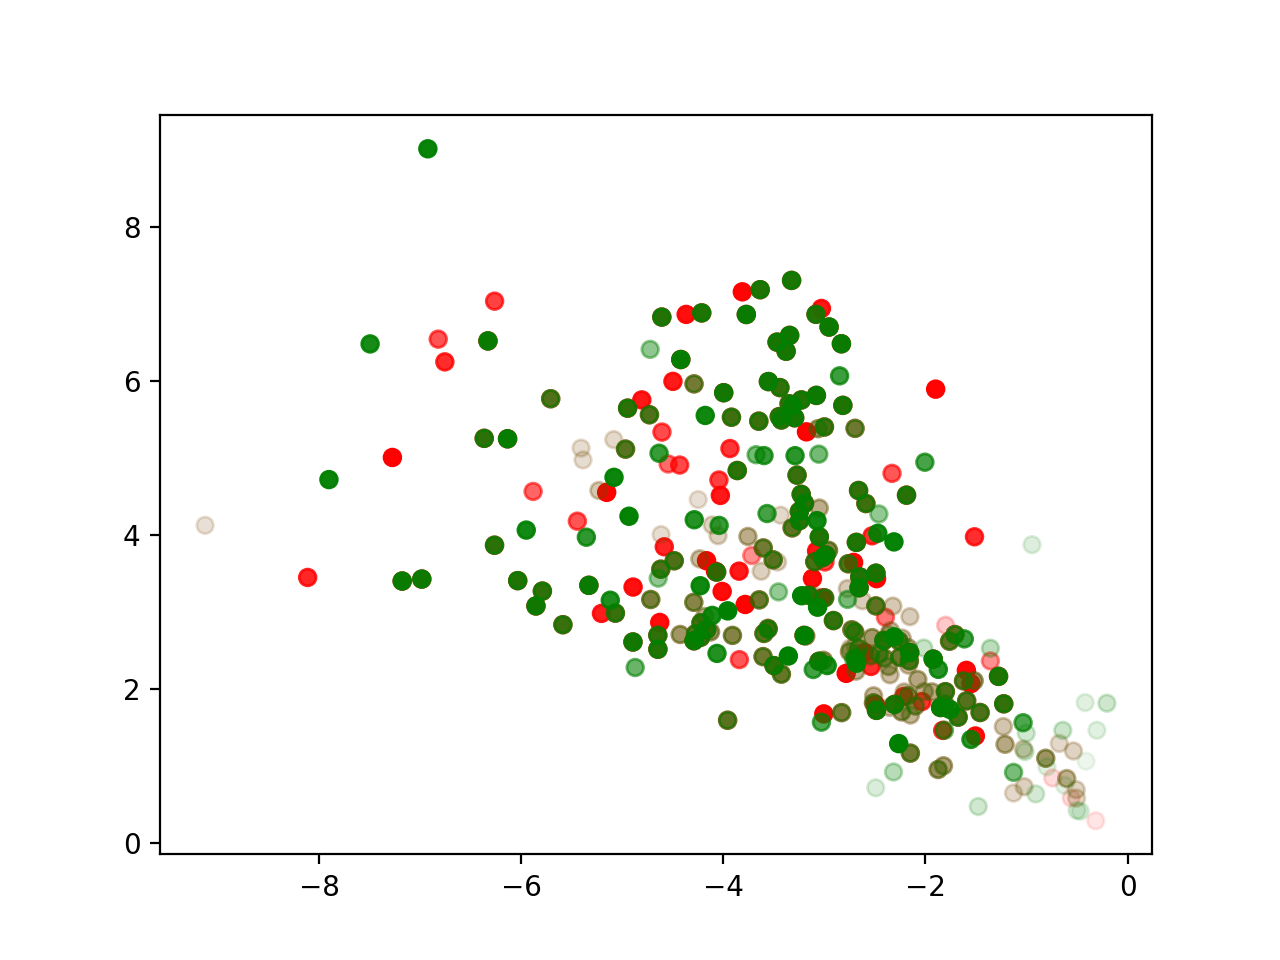

In [26]:
fig, ax = plt.subplots()
ax.scatter(combined_BF_df['speed_left'],combined_BF_df['speed_right'], alpha=combined_BF_df['coverage_tot'], color='red')
ax.scatter(combined_FL_df['speed_left'],combined_FL_df['speed_right'], alpha=combined_FL_df['coverage_tot'], color='green')
plt.show()

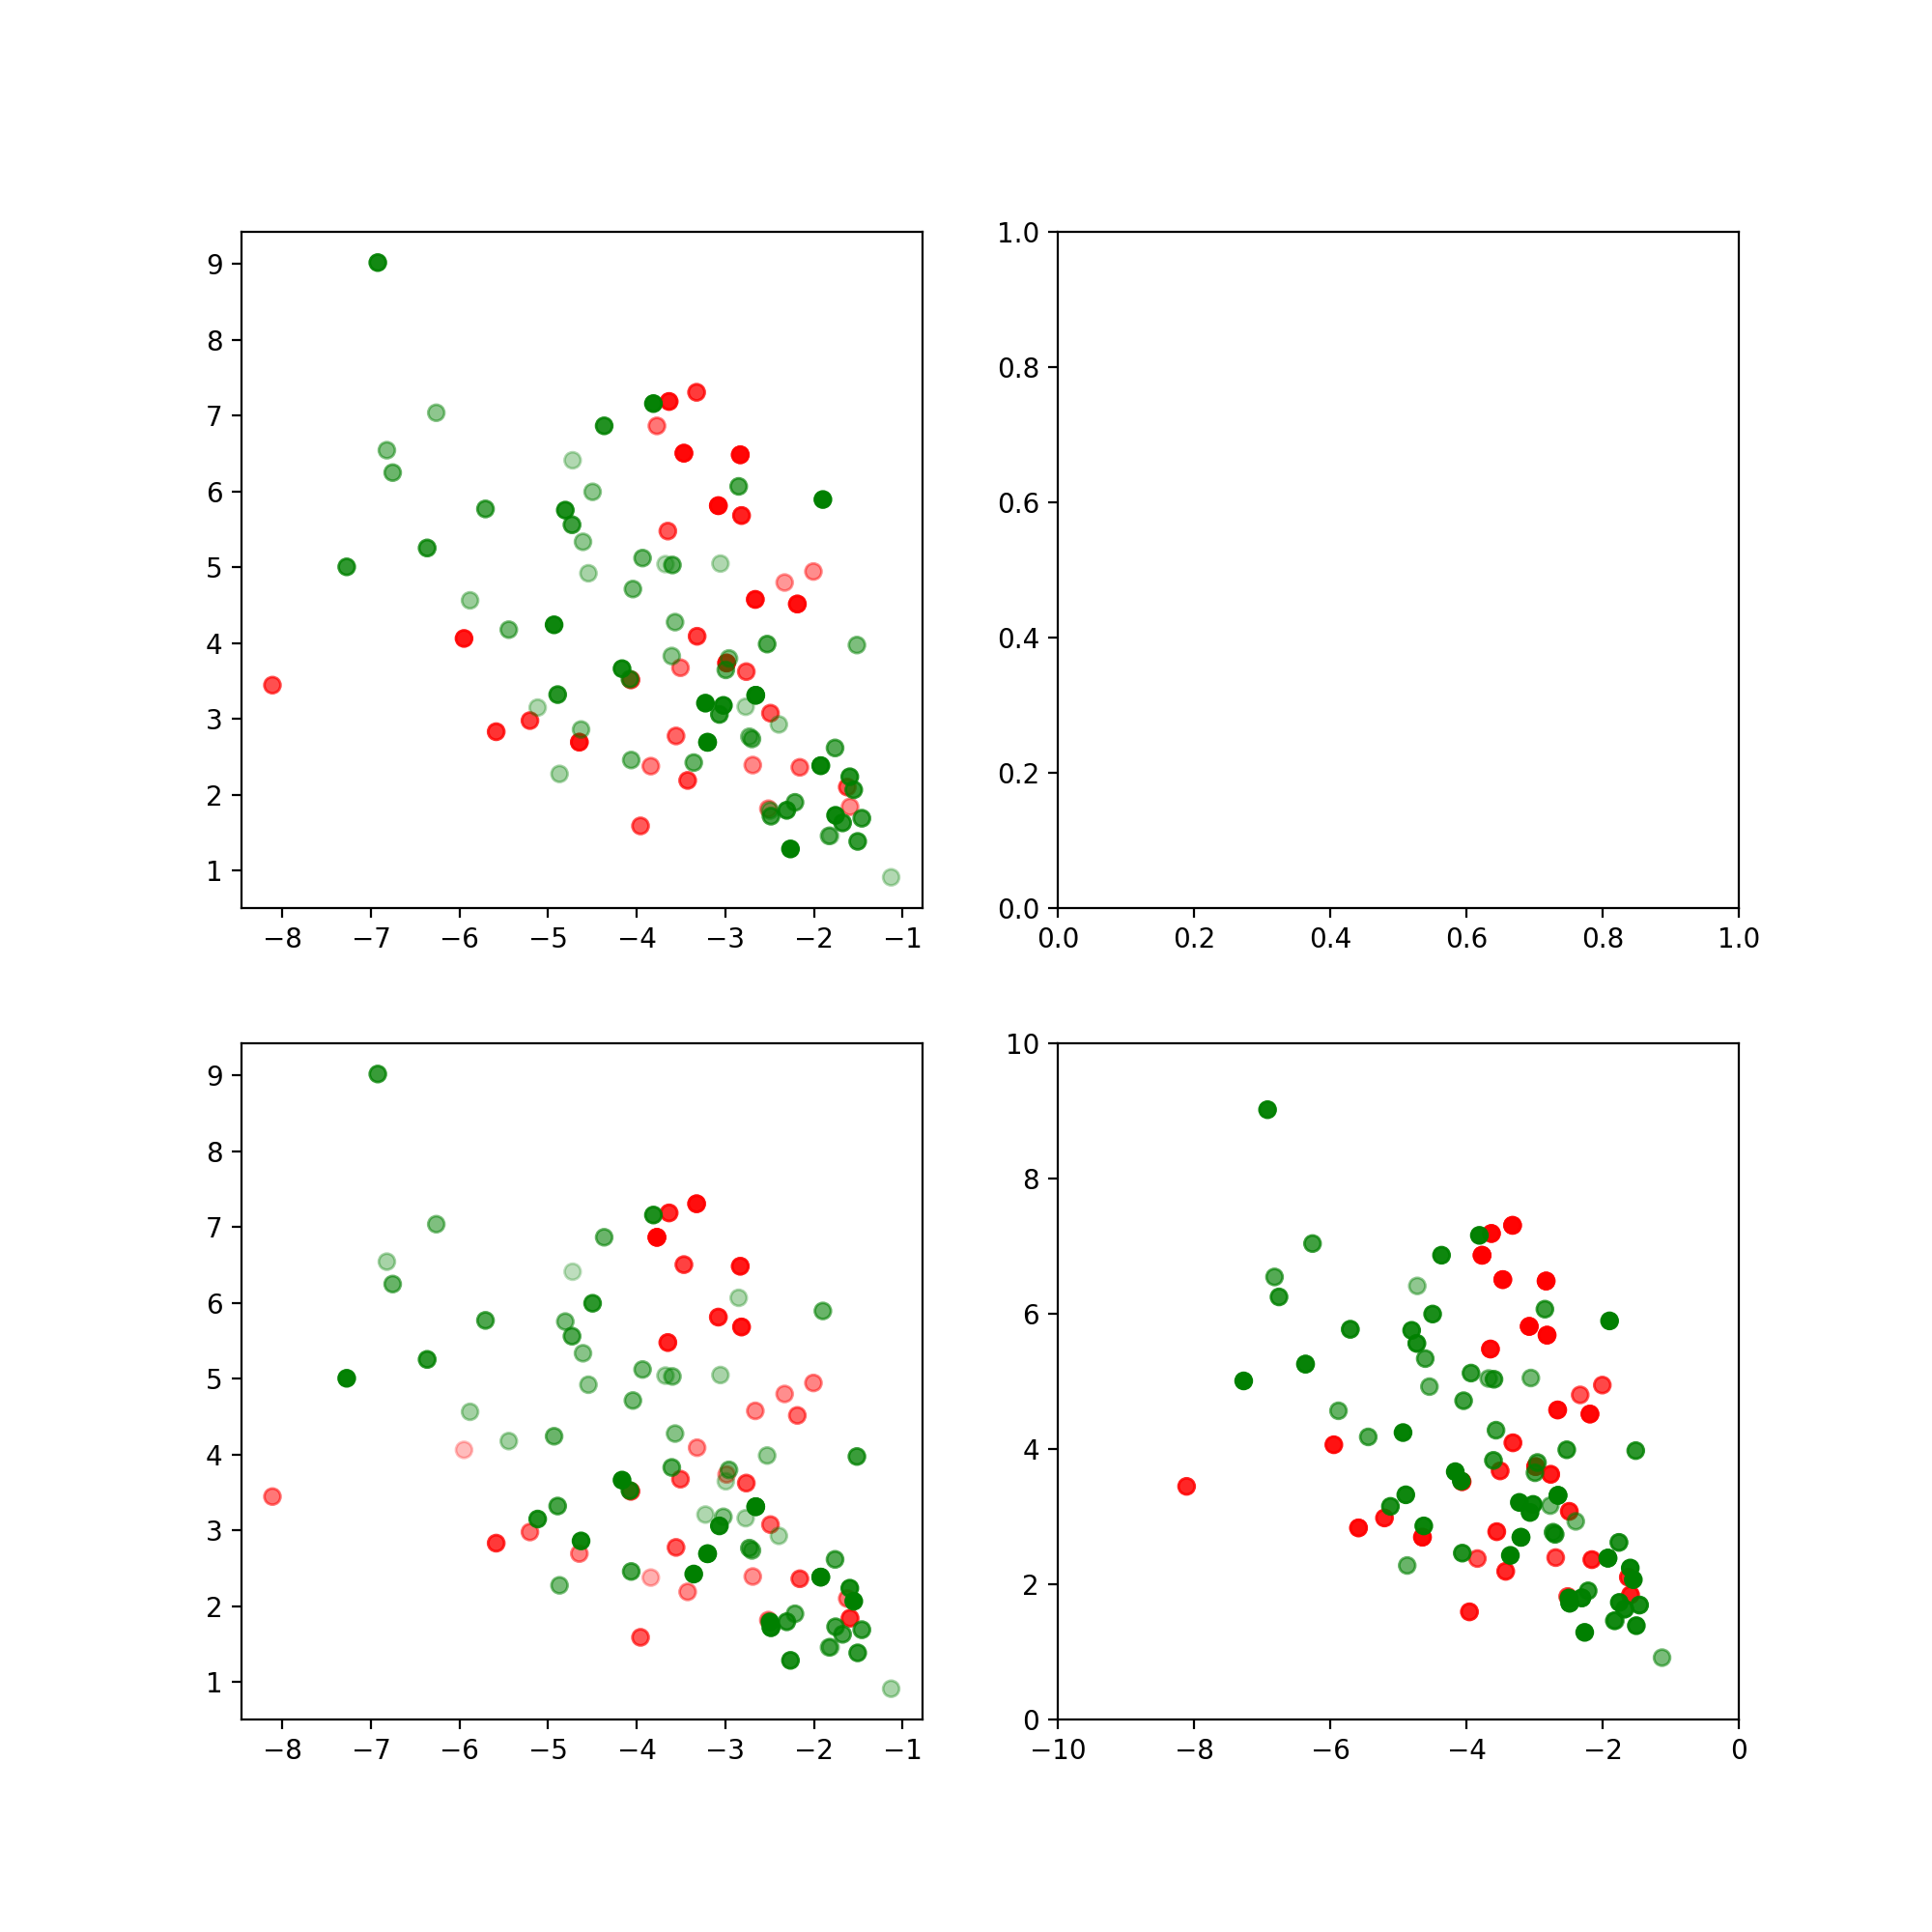

In [8]:
plt.close('all')
fig, ax = plt.subplots(2,2, figsize=(10, 10))
plt.xlim(-10,0)
plt.ylim(0,10)
ax[0][0].scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=BF_df['coverage_left'], color='red')
ax[0][0].scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=FL_df['coverage_left'], color='green')
ax[1][0].scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=BF_df['coverage_right'], color='red')
ax[1][0].scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=FL_df['coverage_right'], color='green')
ax[1][1].scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=BF_df['coverage_tot'], color='red')
ax[1][1].scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=FL_df['coverage_tot'], color='green')
plt.show()

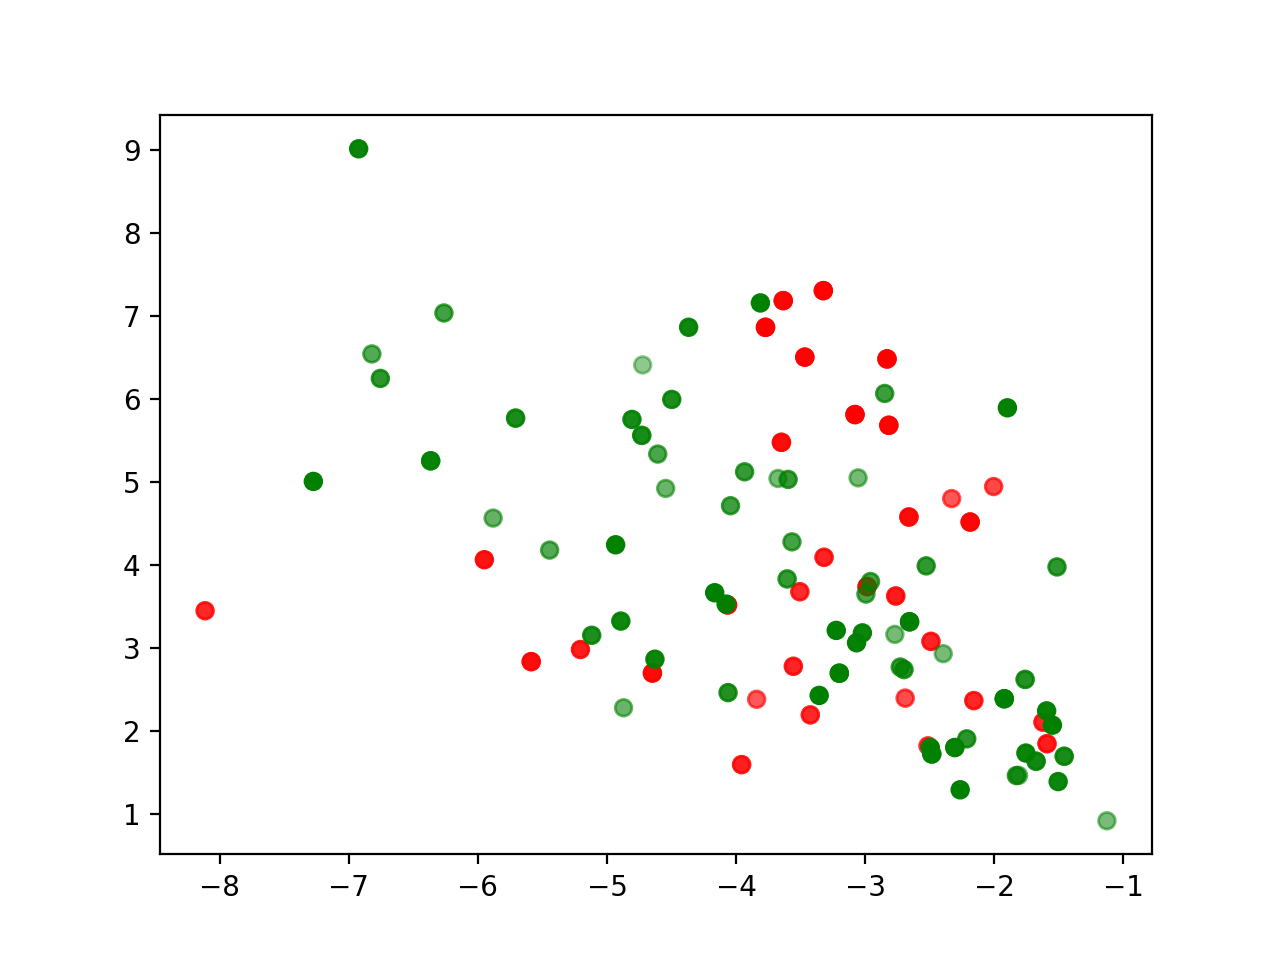

In [9]:
plt.close('all')
fig, ax = plt.subplots()
ax.scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=BF_df['coverage_tot'], color='red')
ax.scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=FL_df['coverage_tot'], color='green')
plt.show()